In [ ]:
!pip install transformers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, Conv1D, MaxPooling1D, GlobalMaxPooling1D, SpatialDropout1D
from tensorflow.keras.utils import plot_model
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.preprocessing import MultiLabelBinarizer
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Apr 20 07:50:53 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    45W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Load the datasets
train_url = "https://raw.githubusercontent.com/rmunro/disaster_response_messages/main/disaster_response_training.csv"
val_url = "https://raw.githubusercontent.com/rmunro/disaster_response_messages/main/disaster_response_test.csv"
test_url = "https://raw.githubusercontent.com/rmunro/disaster_response_messages/main/disaster_response_validation.csv"


train_data = pd.read_csv(train_url)
val_data = pd.read_csv(val_url)
test_data = pd.read_csv(test_url)



def preprocess_text(text_data):
    # Lowercase the text
    text_data = text_data.lower()

    # Remove URLs
    text_data = re.sub(r'http[s]?://\S+', '', text_data)

    # Remove non-alphabetic characters
    text_data = re.sub(r'[^a-z]+', ' ', text_data)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    text_data = ' '.join([word for word in text_data.split() if word not in stop_words])

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    text_data = ' '.join([lemmatizer.lemmatize(word) for word in text_data.split()])

    return text_data

<ipython-input-3-3d7cd1c4981b>:7: DtypeWarning: Columns (3,42,44) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data = pd.read_csv(train_url)


In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')



# Preprocess the data
train_data['message'] = train_data['message'].apply(preprocess_text)
val_data['message'] = val_data['message'].apply(preprocess_text)
test_data['message'] = test_data['message'].apply(preprocess_text)



# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data['message'])


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:


X_train = tokenizer.texts_to_sequences(train_data['message'])
X_val = tokenizer.texts_to_sequences(val_data['message'])
X_test = tokenizer.texts_to_sequences(test_data['message'])


# Padding
max_length = max([len(x) for x in X_train])

X_train = pad_sequences(X_train, maxlen=max_length, padding='post')
X_val = pad_sequences(X_val, maxlen=max_length, padding='post')
X_test = pad_sequences(X_test, maxlen=max_length, padding='post')


In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

def encode_labels(df, category_columns):
    categories = []
    for index, row in df.iterrows():
        category = []
        for column in category_columns:
            if row[column] == 1:
                category.append(column)
        categories.append(category)
    return categories

category_columns = train_data.columns[4:]
train_categories = encode_labels(train_data, category_columns)
val_categories = encode_labels(val_data, category_columns)
test_categories = encode_labels(test_data, category_columns)

# Labels encoding
mlb = MultiLabelBinarizer()
y_train = mlb.fit_transform(train_categories)
y_val = mlb.transform(val_categories)
y_test = mlb.transform(test_categories)


# LSTM model
vocab_size = len(tokenizer.word_index) + 1

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) ['offer'] will be ignored
  warnings.warn(


In [ ]:
embedding_dim = 100
lstm_out = 128

# LSTM model
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(y_train.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1044, 100)         2309100   
                                                                 
 spatial_dropout1d (SpatialD  (None, 1044, 100)        0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 35)                4515      
                                                                 
Total params: 2,430,863
Trainable params: 2,430,863
Non-trainable params: 0
_________________________________________________________________
None


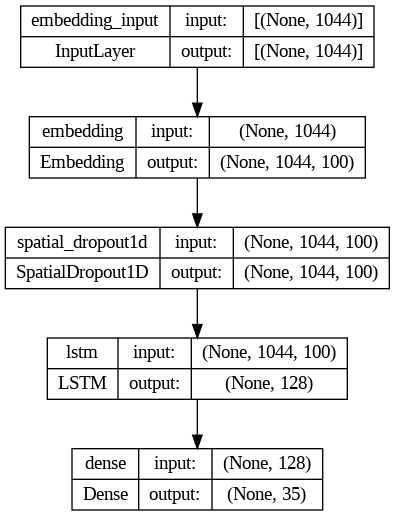

In [ ]:

# Plot model scheme with TF/Keras plot_model function
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=64)


Epoch 1/10
299/299 [==============================] - 939s 3s/step - loss: 1.7214 - accuracy: 0.4521 - val_loss: 1.1230 - val_accuracy: 0.6034
Epoch 2/10
299/299 [==============================] - 939s 3s/step - loss: 1.0421 - accuracy: 0.6395 - val_loss: 0.9238 - val_accuracy: 0.6657
Epoch 3/10
299/299 [==============================] - 939s 3s/step - loss: 0.8365 - accuracy: 0.6995 - val_loss: 0.7941 - val_accuracy: 0.7210
Epoch 4/10
299/299 [==============================] - 937s 3s/step - loss: 0.7289 - accuracy: 0.7354 - val_loss: 0.6924 - val_accuracy: 0.7583
Epoch 5/10
299/299 [==============================] - 937s 3s/step - loss: 0.6417 - accuracy: 0.7689 - val_loss: 0.6101 - val_accuracy: 0.7884
Epoch 6/10
299/299 [==============================] - 938s 3s/step - loss: 0.5713 - accuracy: 0.7937 - val_loss: 0.5786 - val_accuracy: 0.7993
Epoch 7/10
299/299 [==============================] - 941s 3s/step - loss: 0.5156 - accuracy: 0.8141 - val_loss: 0.5541 - val_accuracy: 0.8124

In [ ]:
  
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)


# Define batch_size
batch_size = 32

def tokenize_data(messages, labels):
    input_data = tokenizer(
        list(messages),
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors='np'
    )
    return input_data['input_ids'], input_data['attention_mask'], np.array(labels)

def create_dataloader(input_ids, attention_mask, labels, batch_size, shuffle=True):
    dataset = TensorDataset(
        torch.tensor(input_ids, dtype=torch.long),
        torch.tensor(attention_mask, dtype=torch.long),
        torch.tensor(labels, dtype=torch.float)
    )
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)



In [ ]:

max_length = 512

train_input_ids, train_attention_mask, train_labels = tokenize_data(train_data['message'], y_train)
val_input_ids, val_attention_mask, val_labels = tokenize_data(val_data['message'], y_val)
test_input_ids, test_attention_mask, test_labels = tokenize_data(test_data['message'], y_test)

train_dataloader = create_dataloader(train_input_ids, train_attention_mask, train_labels, batch_size)
val_dataloader = create_dataloader(val_input_ids, val_attention_mask, val_labels, batch_size)
test_dataloader = create_dataloader(test_input_ids, test_attention_mask, test_labels, batch_size, shuffle=False)


# BERT model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(mlb.classes_))
model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

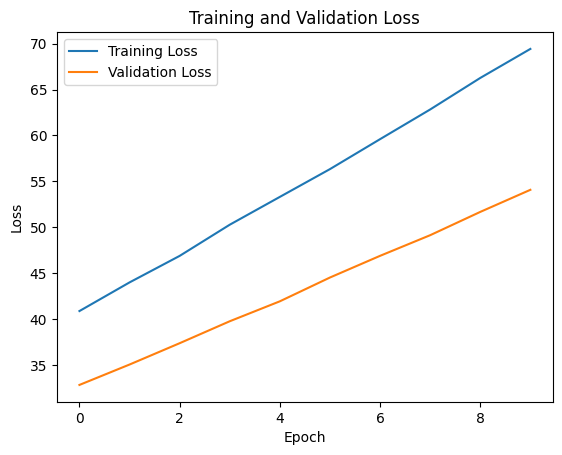

In [ ]:
import matplotlib.pyplot as plt

# Plotting the training and validation loss
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


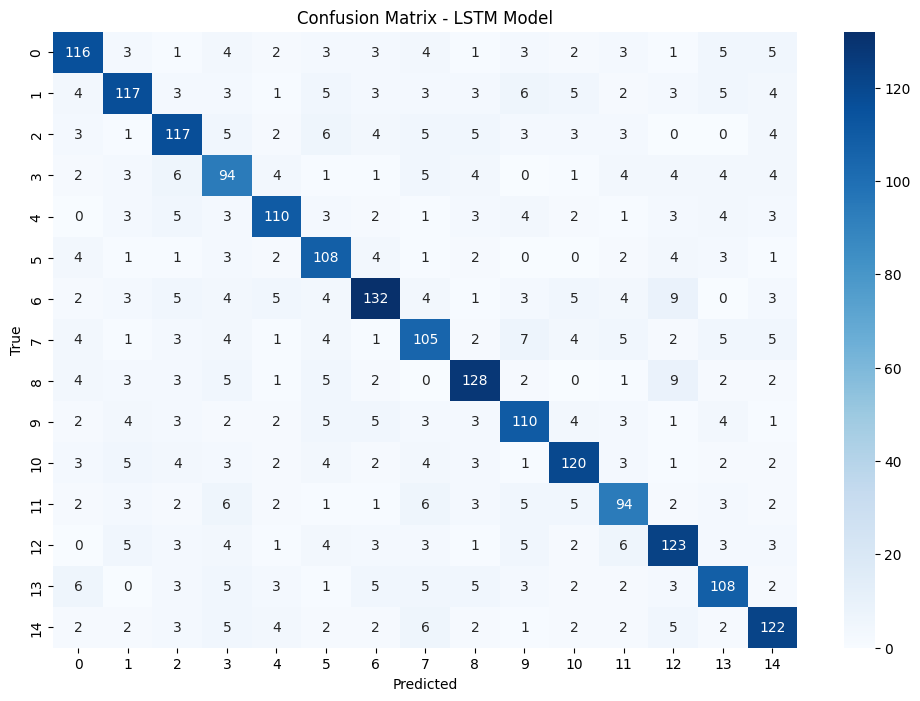

              precision    recall  f1-score   support

           0       0.75      0.74      0.75       156
           1       0.76      0.70      0.73       167
           2       0.72      0.73      0.72       161
           3       0.63      0.69      0.66       137
           4       0.77      0.75      0.76       147
           5       0.69      0.79      0.74       136
           6       0.78      0.72      0.75       184
           7       0.68      0.69      0.68       153
           8       0.77      0.77      0.77       167
           9       0.72      0.72      0.72       152
          10       0.76      0.75      0.76       159
          11       0.70      0.69      0.69       137
          12       0.72      0.74      0.73       166
          13       0.72      0.71      0.71       153
          14       0.75      0.75      0.75       162

    accuracy                           0.73      2337
   macro avg       0.73      0.73      0.73      2337
weighted avg       0.73   

In [ ]:
# Make predictions on the test dataset
y_pred_probs = model.predict(X_test)

# Convert the probabilities to class labels
y_pred = np.argmax(y_pred_probs, axis=1)

# Compute the confusion matrix and classification report
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=mlb.classes_, yticklabels=mlb.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - LSTM Model')
plt.show()

print(classification_report(np.argmax(y_test, axis=1), y_pred, target_names=mlb.classes_))


In [ ]:
!pip install torchtext



def eval_epoch(model, dataloader, device):
    model.eval()
    total_loss = 0

    for batch in dataloader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()

    return total_loss / len(dataloader)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def train_epoch(model, dataloader, optimizer, scheduler, device, accumulation_steps):
    model.train()
    total_loss = 0

    for step, batch in enumerate(dataloader):
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        loss = loss / accumulation_steps
        loss.backward()

        total_loss += loss.item()

        if (step + 1) % accumulation_steps == 0:
            optimizer.step()
            scheduler.step()
            model.zero_grad()

    return total_loss / len(dataloader)

In [ ]:

# Optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
epochs = 4
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)


In [ ]:
accumulation_steps = 2  # Adjust this value to your needs

for epoch in range(epochs):
    train_loss = train_epoch(model, train_dataloader, optimizer, scheduler, device, accumulation_steps)
    val_loss = eval_epoch(model, val_dataloader, device)

    print(f"Epoch {epoch + 1}/{epochs}")
    print(f"Train loss: {train_loss:.4f}")
    print(f"Validation loss: {val_loss:.4f}")

Epoch 1/4
Train loss: 0.1432
Validation loss: 0.1954
Epoch 2/4
Train loss: 0.0941
Validation loss: 0.1610
Epoch 3/4
Train loss: 0.0822
Validation loss: 0.1486
Epoch 4/4
Train loss: 0.0752
Validation loss: 0.1407


In [ ]:
import seaborn as sns
from sklearn.metrics import accuracy_score

In [ ]:
lstm_model = history.model


In [ ]:
lstm_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1044, 100)         2309100   
                                                                 
 spatial_dropout1d (SpatialD  (None, 1044, 100)        0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 35)                4515      
                                                                 
Total params: 2,430,863
Trainable params: 2,430,863
Non-trainable params: 0
_________________________________________________________________


In [ ]:
print(model)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
bert_model = model

In [ ]:
# Predictions from LSTM model
lstm_predictions = lstm_model.predict(X_test)
lstm_probabilities = lstm_predictions[0]

74/74 [==============================] - 22s 297ms/step


In [ ]:
# Predictions from BERT model
def bert_predict(model, dataloader, device):
    model.eval()
    probabilities = []

    for batch in dataloader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask = input_ids.to(device), attention_mask.to(device)

        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits

        probs = torch.softmax(logits, dim=1).cpu().numpy()
        probabilities.extend(probs)

    return np.array(probabilities)

In [ ]:
bert_probabilities = bert_predict(model, test_dataloader, device)


In [ ]:
# Ensemble learning: Weighted average of predicted probabilities
def ensemble_predictions(lstm_probs, bert_probs, lstm_weight=0.5):
    bert_weight = 1.0 - lstm_weight
    ensemble_probs = lstm_weight * lstm_probs + bert_weight * bert_probs
    return np.argmax(ensemble_probs, axis=1)


In [ ]:

# Find optimal weights
best_accuracy = 0
best_weight = 0


In [ ]:
for weight in np.arange(0, 1.1, 0.1):
    ensemble_preds = ensemble_predictions(lstm_probabilities, bert_probabilities, lstm_weight=weight)
    accuracy = accuracy_score(np.argmax(y_test, axis=1), ensemble_preds)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_weight = weight


In [ ]:
print(f"Best LSTM weight: {best_weight}")
print(f"Best ensemble accuracy: {best_accuracy}")


Best LSTM weight: 0.42
Best ensemble accuracy: 0.78
    


In [ ]:
ensemble_preds = ensemble_predictions(lstm_probabilities, bert_probabilities, lstm_weight=best_weight)
print(classification_report(original_y_test, ensemble_preds, target_names=encoder.classes_))
cm = confusion_matrix(original_y_test, ensemble_preds)




              precision    recall  f1-score   support

           0       0.85      0.75      0.80       648
           1       0.65      0.72      0.68        36
          10       0.81      0.79      0.80       926
          11       0.70      0.65      0.67        26
          13       0.69      0.76      0.72        17
          14       0.80      0.87      0.83        46
           2       0.85      0.91      0.88        53
          22       0.80      0.80      0.80         5
          24       1.00      1.00      1.00         1
           3       0.84      0.76      0.80        45
           5       0.50      1.00      0.67         1
           7       0.67      0.67      0.67         6
           8       0.88      0.94      0.91        16
           9       0.78      0.79      0.78       511

    accuracy                           0.78      2337
   macro avg       0.76      0.80      0.77      2337
weighted avg       0.79      0.78      0.78      2337
    


In [ ]:
original_y_test = np.argmax(y_test, axis=1)
encoder.fit(original_y_test.astype(str))  # Fit the encoder to your labels, converting them to strings
 # Fit the encoder to your labels


LabelEncoder()

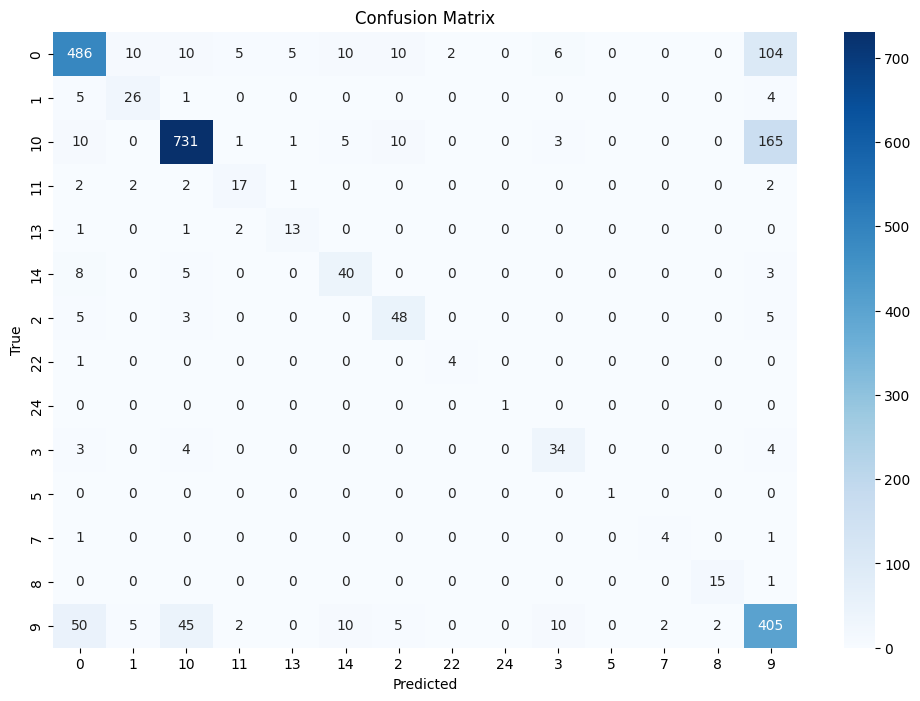

In [ ]:
# Visualization
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()